In [98]:
suppressMessages(library("rwwa"))

# Revert synthesis functions to match climate explorer

In [99]:
getsynmean_cx <- function(data, sig_mod = 0) {

  # calculate weight for each model based on inverse variance
  w = 1/(((data$upper - data$lower))^2 + (2*sig_mod)^2)     # w = 1/(((data$upper - data$lower)/(2*1.96))^2 + sig_mod^2)
  w1 = sum(w)
    
#     print(w)

  # weighted sum of squares & bounds
  s1 <- sum(w*data$est) / w1
  ss2 <- apply(data[,c("est", "lower", "upper")], 2, function(b) sum((w*(data$est - b))^2))
  ss2 <- sqrt(ss2) / w1

  # if non-zero model representation error, extend 95% intervals accordingly
  if (sig_mod > 0) {
      ss2 <- sqrt(ss2^2 + (2*sig_mod)^2)     # ss2 <- sqrt(ss2^2 + (1.96*sig_mod)^2)
  }

  return(s1 + (ss2 * c(0,-1,1)))
}

In [100]:
getsynchi2_cx <- function(data, sig_mod = 0) {

  # function to be minimized by finding sig_mod such that chi^2/mdof ~= 1

  # get best estimate of weighted mean
  s1 <- getsynmean_cx(data, sig_mod)["est"]

  # compute chi2 by converting model intervals to standard deviations & adding sig_mod adjustment
  chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
    if(x["est"] > s1) {
      (x["est"] - s1)^2 / (((x["est"] - x["lower"]))^2 + sig_mod^2)     # (x["est"] - s1)^2 / (((x["est"] - x["lower"])/1.96)^2 + sig_mod^2)
    } else {
      (x["est"] - s1)^2 / (((x["est"] - x["upper"]))^2 + sig_mod^2)     # (x["est"] - s1)^2 / (((x["est"] - x["upper"])/1.96)^2 + sig_mod^2)
    }
  }))
  return(chi2*4)
}

In [101]:
synthesis_cx <- function(obs_in = NA, models_in, synth_type = "abs") {

  if(is.na(unlist(obs_in))[1]) {
    no_obs <- T
    # create a dummy dataframe to avoid having to rewrite everything twice
    obs_in <- data.frame("est" = 0, "lower" = 0, "upper" = 0)
    rownames(obs_in) <- "dummy"
  } else {
    no_obs <- F
  }

  # relabel the data for easier reference later
  colnames(obs_in) <- colnames(models_in) <- c("est", "lower", "upper")

  if(!("model" %in% colnames(obs_in))) obs_in$model <- rownames(obs_in)
  if(!("model" %in% colnames(models_in))) models_in$model <- rownames(models_in)

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

  if(!synth_type %in% c("abs", "rel", "PR")) {
    cat(paste0("Synthesis type '",synth_type,"' not implemented - must be abs, rel or PR"), "\n")
  }

  if(synth_type == "PR") {
    obs_in[,c("est", "lower", "upper")] <- log(obs_in[,c("est", "lower", "upper")])
    models_in[,c("est", "lower", "upper")] <- log(models_in[,c("est", "lower", "upper")])
  } else if(synth_type == "rel") {
    obs_in[,c("est", "lower", "upper")] <- log(1+obs_in[,c("est", "lower", "upper")]/100)
    models_in[,c("est", "lower", "upper")] <- log(1+models_in[,c("est", "lower", "upper")]/100)
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # get mean of intervals to estimate natural variability component

  # compute representation error from scatter of mean ($\sigma_{rep}$ in the paper)
  nobs = nrow(obs_in)
  obs <- apply(obs_in[,c("est", "lower", "upper"),drop = F], 2, mean)
  if(nobs == 1) {
    sig_obs = 0
  } else {
    s2 = sum((obs_in$est - obs[1])^2)
    sig_obs = 2 * sqrt(s2/(nobs-1))     # sig_obs = sqrt(s2/(nobs-1))
  }

  # add representation error to individual observations
  obs_in$l_wb <- obs_in$est - sqrt((obs_in$est - obs_in$lower)**2 + (sig_obs)**2)     # obs_in$l_wb <- obs_in$est - sqrt((obs_in$est - obs_in$lower)**2 + (1.96*sig_obs)**2)
  obs_in$u_wb <- obs_in$est + sqrt((obs_in$est - obs_in$upper)**2 + (sig_obs)**2)     # obs_in$u_wb <- obs_in$est + sqrt((obs_in$est - obs_in$upper)**2 + (1.96*sig_obs)**2)

  # apply representation error to obs synthesis
  # we're working with confidence intervals here, so we extend them by adding (1.96sig_obs)^2 in quadrature
  obs[2] <- obs[1] - sqrt( (obs[1] - obs[2])**2 + (sig_obs)**2 )     # obs[2] <- obs[1] - sqrt( (obs[1] - obs[2])**2 + (1.96*sig_obs)**2 )
  obs[3] <- obs[1] + sqrt( (obs[1] - obs[3])**2 + (sig_obs)**2 )     # obs[3] <- obs[1] + sqrt( (obs[1] - obs[3])**2 + (1.96*sig_obs)**2 )

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # get initial estimate of model mean & calculate chi^2
  chi2 <- getsynchi2_cx(models_in, sig_mod = 0)
  mdof <- nrow(models_in)-1

  if ( chi2/mdof > 1 ) {
    # find sig_mod such that chi^2/dof = 1
    sig_mod <- optim(0, function(x) {
        (getsynchi2_cx(models_in, sig_mod = x) - (nrow(models_in)-1))^2},
                     method = "Brent", lower = 0, upper = 5)$par
      } else {
        sig_mod <- 0
      }
    cat("sig_mod: ", sig_mod,"\n")

  # get weighted model mean
  models <- getsynmean_cx(models_in, sig_mod = sig_mod)

  # add representation error to individual models
  models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + (2*sig_mod)**2)     # models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + (2*sig_mod)**2)
  models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + (2*sig_mod)**2)     # models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + (2*sig_mod)**2)

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # weighted mean of models & obs (coloured bar)
  w_obs <- unname((obs["upper"] - obs["lower"])^{-2})
  w_mod <- unname((models["upper"] - models["lower"])^{-2})

  wmean <- (w_obs * obs["est"] + w_mod * models["est"]) / (w_obs + w_mod)
  synth <- setNames(c(wmean,
                      wmean - sqrt( (w_obs*(obs["est"]-obs["lower"]))^2 + (w_mod*(models["est"]-models["lower"]))^2 )/(w_obs+w_mod),
                      wmean + sqrt( (w_obs*(obs["est"]-obs["upper"]))^2 + (w_mod*(models["est"]-models["upper"]))^2 )/(w_obs+w_mod)),
                    c("est", "lower", "upper"))


  # unweighted mean of obs and models
  umean <- (obs["est"] +  models["est"]) / 2
  synth["l_wb"] <- umean - sqrt((obs["est"]-obs["lower"])^2 + (models["est"]-models["lower"])^2)/2
  synth["u_wb"] <- umean + sqrt((obs["est"]-obs["upper"])^2 + (models["est"]-models["upper"])^2)/2

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # add group labels for easier plotting
  obs_in <- cbind(obs_in, "group" = "obs")
  obs <- data.frame(t(c("model" = "Observations", "group" = "obs_synth", obs)))
  models_in <- cbind(models_in, "group" = "models")
  models <- data.frame(t(c("model" = "Models", "group" = "model_synth", models)))
  synth <- data.frame(t(c("model" = "Synthesis", "group" = "synth", synth)))

  # combine all the data together in one dataframe
  res <- rbind.fill(obs_in, obs, models_in, models, synth)[,c("group", "model", "est", "lower", "upper", "l_wb", "u_wb")]
  for(cnm in c("est", "lower", "upper", "l_wb", "u_wb")) { res[,cnm] <- as.numeric(res[,cnm]) }

  # if only dummy obs, remove
  if(no_obs) {
    # drop all rows that don't relate to models
    res <- res[grepl("model", res$group),]
    sig_obs <- NA
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # reverse any transformations applied
  if(synth_type == "PR") {
    res[,c("est", "lower", "upper", "l_wb", "u_wb")] <- exp(res[,c("est", "lower", "upper", "l_wb", "u_wb")])
    sig_obs <- exp(sig_obs)
    sig_mod <- exp(sig_mod)
    umean <- exp(umean)
  } else if(synth_type == "rel") {
    res[,c("est", "lower", "upper", "l_wb", "u_wb")] <- 100*(exp(res[,c("est", "lower", "upper", "l_wb", "u_wb")])-1)
    sig_obs <- 100*(exp(sig_obs)-1)
    sig_mod <- 100*(exp(sig_mod)-1)
    umean <- 100*(exp(umean)-1)
  }

  return(list(synth_type = synth_type, sig_obs = sig_obs, "chi2/dof" = chi2 / mdof, df = res, uw_mean = umean))
}

In [102]:
df = read.csv("dI_sahel-tx5x-future.txt", sep = "\t", row.names = "model")

In [103]:
synth <- synthesis_cx(models_in = df)
synth$"chi2/dof"     # CX has chi2/dof = 3.716

synth$df
# 3.71572967348589

sig_mod:  0.2091987 


[1] 3.71573

,group,model,est,lower,upper,l_wb,u_wb
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,models,ACCESS-CM2_r1i1p1f1,1.0270000,0.9060000,1.14900,0.5914573,1.462822
4,models,ACCESS-ESM1-5_r1i1p1f1,0.9930000,0.8910000,1.10200,0.5623489,1.425363
5,models,AWI-CM-1-1-MR_r1i1p1f1,0.8260000,0.7240000,0.93400,0.3953489,1.258112
6,models,EC-Earth3_r1i1p1f1,0.9610000,0.8780000,1.04300,0.5344494,1.387357
7,models,EC-Earth3-Veg_r1i1p1f1,1.0430000,0.9480000,1.14500,0.6139529,1.473651
8,models,EC-Earth3-Veg-LR_r1i1p1f1,1.1320000,1.0300000,1.23000,0.7013489,1.561721
9,models,INM-CM5-0_r1i1p1f1,0.8550000,0.7360000,0.95900,0.4200087,1.286129
10,models,MPI-ESM1-2-HR_r1i1p1f1,0.9050000,0.7470000,1.04800,0.4577636,1.347160
11,models,MPI-ESM1-2-LR_r1i1p1f1,0.8750000,0.7300000,1.02100,0.4321892,1.318139


In [104]:
(2*1.96)^2

[1] 15.3664

In [105]:
optim(0, function(x) {(getsynchi2_cx(df, sig_mod = x) - (nrow(df)-1))^2}, method = "Brent", lower = 0, upper = 5)$par

[1] 0.2091987

In [106]:
cx <- read.table("cxsynth_dI_sahel-tx5x-future.txt", col.names = c("y1", "y2", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"))

In [107]:
rbind(cx$est, synth$df$est)

1.030,0.993,0.826,0.961,1.040,1.130,0.855,0.905,0.875,0.98,1.260,0.9830000
1.027,0.993,0.826,0.961,1.043,1.132,0.855,0.905,0.875,0.98,1.261,0.9827894


In [108]:
rbind(cx$lower, synth$df$lower)

0.906,0.891,0.724,0.878,0.948,1.03,0.736,0.747,0.73,0.635,1.070,0.7700000
0.906,0.891,0.724,0.878,0.948,1.03,0.736,0.747,0.73,0.635,1.069,0.5625914


In [109]:
rbind(cx$upper, synth$df$upper)

1.150,1.100,0.934,1.040,1.140,1.23,0.959,1.050,1.020,1.240,1.440,1.20000
1.149,1.102,0.934,1.043,1.145,1.23,0.959,1.048,1.021,1.236,1.438,1.40281


In [110]:
rbind(cx$l_wb, synth$df$l_wb)

0.7850000,0.7600000,0.5930000,0.7360000,0.8130000,0.8990000,0.6140000,0.6430000,0.6200000,0.5770000,0.9770000,0.77
0.5914573,0.5623489,0.3953489,0.5344494,0.6139529,0.7013489,0.4200087,0.4577636,0.4321892,0.4377073,0.8006519,NA


In [111]:
rbind(cx$u_wb, synth$df$u_wb)

1.270000,1.230000,1.060000,1.190000,1.280000,1.360000,1.090000,1.16000,1.130000,1.310000,1.540000,1.2
1.462822,1.425363,1.258112,1.387357,1.473651,1.561721,1.286129,1.34716,1.318139,1.470502,1.715297,NA


# Check equations

## Equal means, equal variances

The more models we add, the more we shrink toward the mean. This is not how we handle the obs - which do we want to do?

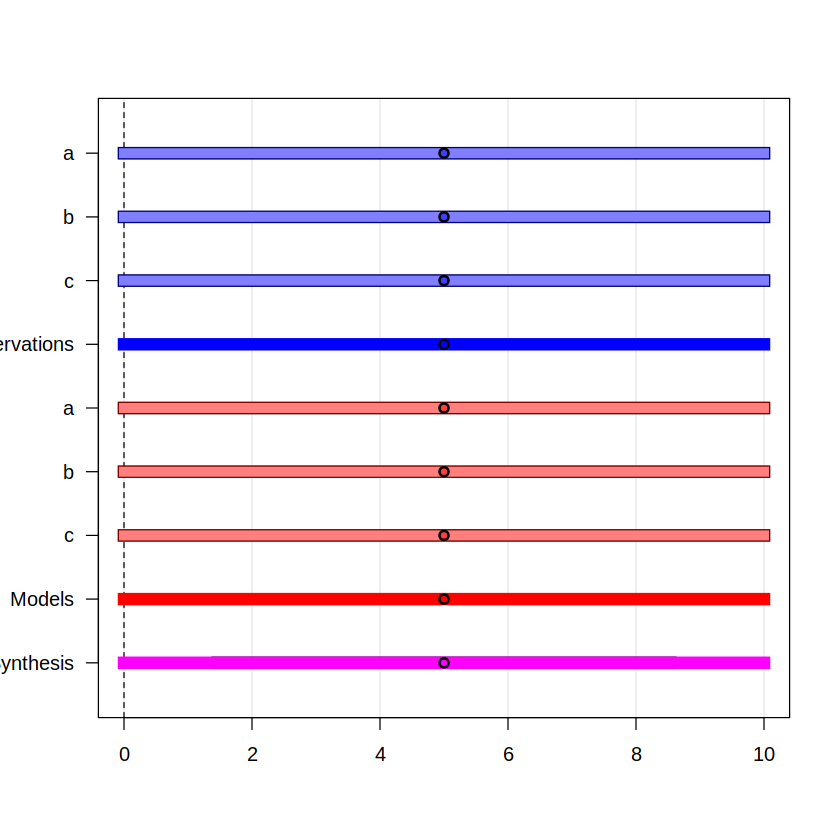

In [112]:
# specify model parameters
n = 3
mu = rep(5,n)
sigma = (10 - mu) / qnorm(0.975)
sig_mod = 0

# turn variances into bounds and run through synthesis
sim_bounds <- data.frame(t(sapply(1:length(mu), function(j) setNames(c(mu[j], qnorm(c(0.025, 0.975), mu[j], sigma[j]+sig_mod)), c("est", "lower", "upper")))),
                         row.names = letters[1:length(mu)])

zz = synthesis(obs_in = sim_bounds, models_in = sim_bounds)
plot_synthesis(zz, add_space = F)

In [113]:
# width of obs interval
int_obs = diff(unlist(zz$df[zz$df$group == "obs_synth",c("est", "upper")])) 
int_mdl = diff(unlist(zz$df[zz$df$group == "model_synth",c("est", "upper")]))

# ratio of model interval to obs interval is sqrt(n)
(int_obs / int_mdl)^2

upper 
    1

### Obs synthesis

In [114]:
mu_obs = 1/n * sum(mu)

# check width of obs interval
sig_obs = 1/n * sum(sigma)
mu_obs + qnorm(0.975) * sig_obs

[1] 10

### Model synthesis

The individual model weights are
$\begin{align}
&w_j = \frac{k}{\sigma_j^2}
\end{align}$ where $k = \left(2 \times 1.96\right)^{-2}$.


In [115]:
# calculate weights from sigma - should match print when running synthesis
w = round(1/(((2*1.96)^2) * sigma^2), 2)
w

[1] 0.01 0.01 0.01

The upper bound of the dark red bar is 
$\begin{align}\mu_{mod} + \frac{1.96}{\sqrt{\sum_j \sigma_j^{-2}}}
\end{align}$

In [116]:
# model mean
mu_mod = sum(w*mu)/sum(w)

# model SD
sqrt(sum((w*sigma)^2)) / sum(w)

# and again, but this time using sum of precisions directly
sig_mod = 1/sqrt(sum(1/sigma^2))
sig_mod

[1] 1.472859

[1] 1.472859

In [117]:
# check the upper limit of the interval
mu_mod + qnorm(0.975) * sig_mod
zz$df[zz$df$group == "model_synth", "upper"]

[1] 7.886751

[1] 10

### Overall synthesis

In [118]:
# compute weights
k = (2*1.96)^2
w_obs = k / sig_obs^2
w_mod = k / sig_mod^2

In [119]:
# compute synthesised mean
mu_synth = mean(mu_mod, mu_obs)

# synthesised variance
sig_synth = 1/sqrt(sig_obs^{-2} + sig_mod^{-2})

In [120]:
# check bounds
mu_synth + qnorm(0.975) * sig_synth
zz$df[zz$df$group == "synth","upper"]

[1] 7.5

[1] 10

## All obs agree, all models agree but are biased

Still heavily prioritising the models even though the same number of obs are also in full agreement

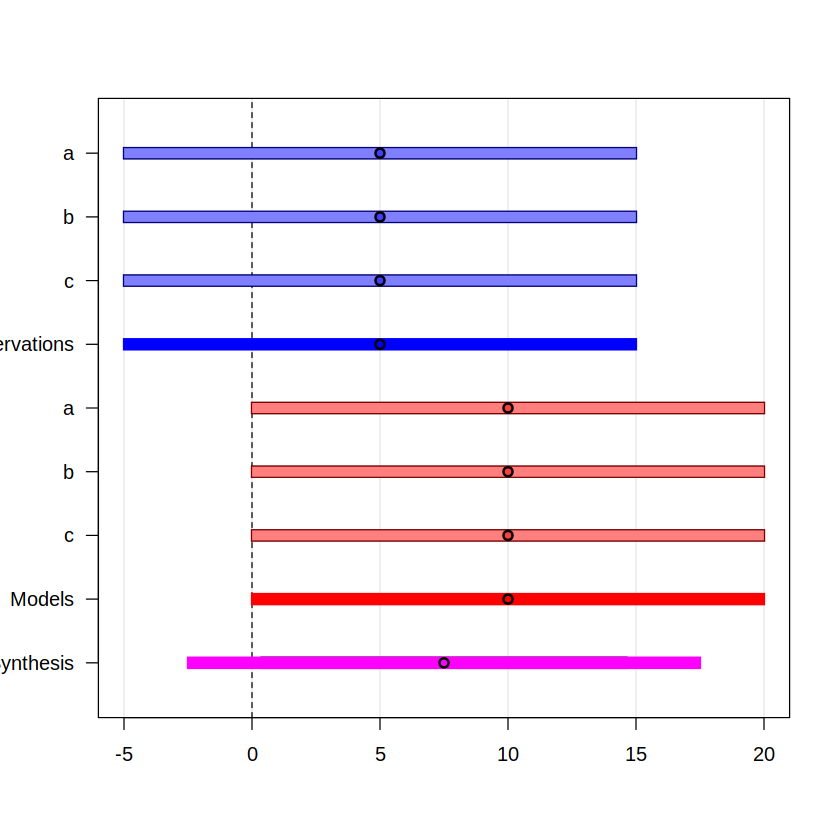

In [121]:
# specify model parameters
n = 3
mu_obs = rep(5, n)
mu_mod = rep(10,n)

sigma_obs = rep(5, n)
sigma_mod = rep(5, n)

# turn variances into bounds and run through synthesis
obs_bounds <- data.frame(t(sapply(1:length(mu_obs), function(j) setNames(c(mu_obs[j], qnorm(c(0.025, 0.975), mu_obs[j], sigma_obs[j])), c("est", "lower", "upper")))),
                         row.names = letters[1:length(mu_obs)])
                           
mdl_bounds <- data.frame(t(sapply(1:length(mu_mod), function(j) setNames(c(mu_mod[j], qnorm(c(0.025, 0.975), mu_mod[j], sigma_mod[j])), c("est", "lower", "upper")))),
                         row.names = letters[1:length(mu_mod)])

zz = synthesis(obs_in = obs_bounds, models_in = mdl_bounds)
plot_synthesis(zz, add_space = F)

---
# Modified synthesis functions

## v1 - correction to `sig_mod` ($\sigma_{mrep}$)
`getsynmean`
- weights corrected (was mixing interval width & SD)
- add interval based on sig_mod, rather than just sig_mod  

`getsynchi2`
- convert interval width to standard deviation

In [122]:
v1_desc <- "V1: model uncertainty updated"

In [123]:
getsynmean_v1 <- function(data, sig_mod = 0) {

  # calculate weight for each model based on inverse variance
  w = 1/(((data$upper - data$lower)/(2*1.96))^2 + (sig_mod)^2)                                             # updated to match eq 9 in paper
  w1 = sum(w)
    
#   print(w)

  # weighted sum of squares & bounds
  s1 <- sum(w*data$est) / w1
  ss2 <- apply(data[,c("est", "lower", "upper")], 2, function(b) sum((w*(data$est - b))^2))                # no change yet - working with squared interval widths 
  ss2 <- sqrt(ss2) / w1

  # if non-zero model representation error, extend 95% intervals accordingly
  if (sig_mod > 0) {
      ss2 <- sqrt(ss2^2 + (1.96*sig_mod)^2)                                                                # add mrep to interval width
  }

  return(s1 + (ss2 * c(0,-1,1)))
}

In [124]:
getsynchi2_v1 <- function(data, sig_mod = 0) {

  # function to be minimized by finding sig_mod such that chi^2/mdof ~= 1

  # get best estimate of weighted mean
  s1 <- getsynmean_v1(data, sig_mod)["est"]

  # compute chi2 by converting model intervals to standard deviations & adding sig_mod adjustment
  chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
    if(x["est"] > s1) {
      (x["est"] - s1)^2 / (((x["est"] - x["lower"])/1.96)^2 + sig_mod^2)              # convert interval width to standard deviation
    } else {
      (x["est"] - s1)^2 / (((x["est"] - x["upper"])/1.96)^2 + sig_mod^2)              # convert interval width to standard deviation
    }
  }))
  return(chi2)                                                                        # no longer necessary to multiply by 4
}

In [125]:
synthesis_v1 <- function(obs_in = NA, models_in, synth_type = "abs") {

  if(is.na(unlist(obs_in))[1]) {
    no_obs <- T
    # create a dummy dataframe to avoid having to rewrite everything twice
    obs_in <- data.frame("est" = 0, "lower" = 0, "upper" = 0)
    rownames(obs_in) <- "dummy"
  } else {
    no_obs <- F
  }

  # relabel the data for easier reference later
  colnames(obs_in) <- colnames(models_in) <- c("est", "lower", "upper")

  if(!("model" %in% colnames(obs_in))) obs_in$model <- rownames(obs_in)
  if(!("model" %in% colnames(models_in))) models_in$model <- rownames(models_in)

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

  if(!synth_type %in% c("abs", "rel", "PR")) {
    cat(paste0("Synthesis type '",synth_type,"' not implemented - must be abs, rel or PR"), "\n")
  }

  if(synth_type == "PR") {
    obs_in[,c("est", "lower", "upper")] <- log(obs_in[,c("est", "lower", "upper")])
    models_in[,c("est", "lower", "upper")] <- log(models_in[,c("est", "lower", "upper")])
  } else if(synth_type == "rel") {
    obs_in[,c("est", "lower", "upper")] <- log(1+obs_in[,c("est", "lower", "upper")]/100)
    models_in[,c("est", "lower", "upper")] <- log(1+models_in[,c("est", "lower", "upper")]/100)
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # get mean of intervals to estimate natural variability component

  # compute representation error from scatter of mean ($\sigma_{rep}$ in the paper)
  nobs = nrow(obs_in)
  obs <- apply(obs_in[,c("est", "lower", "upper"),drop = F], 2, mean)
  if(nobs == 1) {
    sig_obs = 0
  } else {
    s2 = sum((obs_in$est - obs[1])^2)
    sig_obs = 2 * sqrt(s2/(nobs-1))     # sig_obs = sqrt(s2/(nobs-1))
  }

  # add representation error to individual observations
  obs_in$l_wb <- obs_in$est - sqrt((obs_in$est - obs_in$lower)**2 + (sig_obs)**2)
  obs_in$u_wb <- obs_in$est + sqrt((obs_in$est - obs_in$upper)**2 + (sig_obs)**2)

  # apply representation error to obs synthesis
  # we're working with confidence intervals here, so we extend them by adding (1.96sig_obs)^2 in quadrature
  obs[2] <- obs[1] - sqrt( (obs[1] - obs[2])**2 + (sig_obs)**2 )
  obs[3] <- obs[1] + sqrt( (obs[1] - obs[3])**2 + (sig_obs)**2 )

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # get initial estimate of model mean & calculate chi^2
  chi2 <- getsynchi2_v1(models_in, sig_mod = 0)
  mdof <- nrow(models_in)-1

  if ( chi2/mdof > 1 ) {
    # find sig_mod such that chi^2/dof = 1
    sig_mod <- optim(0, function(x) {
        (getsynchi2_v1(models_in, sig_mod = x) - (nrow(models_in)-1))^2},
                     method = "Brent", lower = 0, upper = 5)$par
      } else {
        sig_mod <- 0
      }
    cat("sig_mod: ", sig_mod,"\n")

  # get weighted model mean
  models <- getsynmean_v1(models_in, sig_mod = sig_mod)

  # add representation error to individual models
  models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + (1.96*sig_mod)**2)     # updated from 2x to 1.96x for consistency
  models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + (1.96*sig_mod)**2)     # updated from 2x to 1.96x for consistency

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # weighted mean of models & obs (coloured bar)
  w_obs <- unname((obs["upper"] - obs["lower"])^{-2})
  w_mod <- unname((models["upper"] - models["lower"])^{-2})

  wmean <- (w_obs * obs["est"] + w_mod * models["est"]) / (w_obs + w_mod)
  synth <- setNames(c(wmean,
                      wmean - sqrt( (w_obs*(obs["est"]-obs["lower"]))^2 + (w_mod*(models["est"]-models["lower"]))^2 )/(w_obs+w_mod),
                      wmean + sqrt( (w_obs*(obs["est"]-obs["upper"]))^2 + (w_mod*(models["est"]-models["upper"]))^2 )/(w_obs+w_mod)),
                    c("est", "lower", "upper"))


  # unweighted mean of obs and models
  umean <- (obs["est"] +  models["est"]) / 2
  synth["l_wb"] <- umean - sqrt((obs["est"]-obs["lower"])^2 + (models["est"]-models["lower"])^2)/2
  synth["u_wb"] <- umean + sqrt((obs["est"]-obs["upper"])^2 + (models["est"]-models["upper"])^2)/2

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # add group labels for easier plotting
  obs_in <- cbind(obs_in, "group" = "obs")
  obs <- data.frame(t(c("model" = "Observations", "group" = "obs_synth", obs)))
  models_in <- cbind(models_in, "group" = "models")
  models <- data.frame(t(c("model" = "Models", "group" = "model_synth", models)))
  synth <- data.frame(t(c("model" = "Synthesis", "group" = "synth", synth)))

  # combine all the data together in one dataframe
  res <- rbind.fill(obs_in, obs, models_in, models, synth)[,c("group", "model", "est", "lower", "upper", "l_wb", "u_wb")]
  for(cnm in c("est", "lower", "upper", "l_wb", "u_wb")) { res[,cnm] <- as.numeric(res[,cnm]) }

  # if only dummy obs, remove
  if(no_obs) {
    # drop all rows that don't relate to models
    res <- res[grepl("model", res$group),]
    sig_obs <- NA
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # reverse any transformations applied
  if(synth_type == "PR") {
    res[,c("est", "lower", "upper", "l_wb", "u_wb")] <- exp(res[,c("est", "lower", "upper", "l_wb", "u_wb")])
    sig_obs <- exp(sig_obs)
    sig_mod <- exp(sig_mod)
    umean <- exp(umean)
  } else if(synth_type == "rel") {
    res[,c("est", "lower", "upper", "l_wb", "u_wb")] <- 100*(exp(res[,c("est", "lower", "upper", "l_wb", "u_wb")])-1)
    sig_obs <- 100*(exp(sig_obs)-1)
    sig_mod <- 100*(exp(sig_mod)-1)
    umean <- 100*(exp(umean)-1)
  }

  return(list(synth_type = synth_type, sig_obs = sig_obs, "chi2/dof" = chi2 / mdof, df = res, uw_mean = umean))
}

## v2 - take weighted average of model uncertainty, rather than precision

In [126]:
v2_desc <- "V2: weighted mean of model variances"

In [127]:
getsynmean_v2 <- function(data, sig_mod = 0) {

  # calculate weight for each model based on inverse variance
  w = 1/(((data$upper - data$lower)/(2*1.96))^2 + (sig_mod)^2)                                             # v1: updated to match eq 9 in paper
  w1 = sum(w)

  # weighted mean
  s1 <- sum(w*data$est) / w1
  
  # get weighted interval by adding variances                                                              # v2: get interval as in equation 5, by averaging variances
  sig_lower = 1.96 * sqrt(sum(w * (((data$est - data$lower)/1.96)^2 + sig_mod^2)) / w1)
  sig_upper = 1.96 * sqrt(sum(w * (((data$est - data$upper)/1.96)^2 + sig_mod^2)) / w1)
 
  return(setNames(s1 + c(0, -1.96*sig_lower, +1.96*sig_upper), c("est", "lower", "upper")))
}

In [128]:
getsynmean_v2cx <- function(data, sig_mod = 0) {

  # calculate weight for each model based on inverse variance
  w = 1/(((data$upper - data$lower)/(2*1.96))^2 + (sig_mod)^2)                                             # v1: updated to match eq 9 in paper
  w1 = sum(w)

  # weighted sum of squares & bounds
  s1 <- sum(w*data$est) / w1
  ss2 <- apply(data[,c("est", "lower", "upper")], 2, function(b) sum(w*(data$est - b)/1.96)^2)                # v2: get interval as in equation 5, by averaging variances
  ss2 <- sqrt(ss2) / w1

  # if non-zero model representation error, extend 95% intervals accordingly
  if (sig_mod > 0) {
      ss2 <- sqrt(ss2^2 + (1.96*sig_mod)^2)                                                                # add mrep to interval width
  }

  return(s1 + (ss2 * c(0,-1,1)))
}

In [129]:
getsynchi2_v2 <- function(data, sig_mod = 0) {

  # function to be minimized by finding sig_mod such that chi^2/mdof ~= 1

  # get best estimate of weighted mean
  s1 <- getsynmean_v2(data, sig_mod)["est"]

  # compute chi2 by converting model intervals to standard deviations & adding sig_mod adjustment
  chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
    if(x["est"] > s1) {
      (x["est"] - s1)^2 / (((x["est"] - x["lower"])/1.96)^2 + sig_mod^2)              # v1: convert interval width to standard deviation
    } else {
      (x["est"] - s1)^2 / (((x["est"] - x["upper"])/1.96)^2 + sig_mod^2)              # v1: convert interval width to standard deviation
    }
  }))
  return(chi2)                                                                        # v1: no longer necessary to multiply by 4
}

In [130]:
synthesis_v2 <- function(obs_in = NA, models_in, synth_type = "abs") {

  if(is.na(unlist(obs_in))[1]) {
    no_obs <- T
    # create a dummy dataframe to avoid having to rewrite everything twice
    obs_in <- data.frame("est" = 0, "lower" = 0, "upper" = 0)
    rownames(obs_in) <- "dummy"
  } else {
    no_obs <- F
  }

  # relabel the data for easier reference later
  colnames(obs_in) <- colnames(models_in) <- c("est", "lower", "upper")

  if(!("model" %in% colnames(obs_in))) obs_in$model <- rownames(obs_in)
  if(!("model" %in% colnames(models_in))) models_in$model <- rownames(models_in)

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

  if(!synth_type %in% c("abs", "rel", "PR")) {
    cat(paste0("Synthesis type '",synth_type,"' not implemented - must be abs, rel or PR"), "\n")
  }

  if(synth_type == "PR") {
    obs_in[,c("est", "lower", "upper")] <- log(obs_in[,c("est", "lower", "upper")])
    models_in[,c("est", "lower", "upper")] <- log(models_in[,c("est", "lower", "upper")])
  } else if(synth_type == "rel") {
    obs_in[,c("est", "lower", "upper")] <- log(1+obs_in[,c("est", "lower", "upper")]/100)
    models_in[,c("est", "lower", "upper")] <- log(1+models_in[,c("est", "lower", "upper")]/100)
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # get mean of intervals to estimate natural variability component

  # compute representation error from scatter of mean ($\sigma_{rep}$ in the paper)
  nobs = nrow(obs_in)
  obs <- apply(obs_in[,c("est", "lower", "upper"),drop = F], 2, mean)
  if(nobs == 1) {
    sig_obs = 0
  } else {
    s2 = sum((obs_in$est - obs[1])^2)
    sig_obs = 2 * sqrt(s2/(nobs-1))     # sig_obs = sqrt(s2/(nobs-1))
  }

  # add representation error to individual observations
  obs_in$l_wb <- obs_in$est - sqrt((obs_in$est - obs_in$lower)**2 + (sig_obs)**2)
  obs_in$u_wb <- obs_in$est + sqrt((obs_in$est - obs_in$upper)**2 + (sig_obs)**2)

  # apply representation error to obs synthesis
  # we're working with confidence intervals here, so we extend them by adding (1.96sig_obs)^2 in quadrature
  obs[2] <- obs[1] - sqrt( (obs[1] - obs[2])**2 + (sig_obs)**2 )
  obs[3] <- obs[1] + sqrt( (obs[1] - obs[3])**2 + (sig_obs)**2 )

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # get initial estimate of model mean & calculate chi^2
  chi2 <- getsynchi2_v2(models_in, sig_mod = 0)
  mdof <- nrow(models_in)-1

  if ( chi2/mdof > 1 ) {
    # find sig_mod such that chi^2/dof = 1
    sig_mod <- optim(0, function(x) {
        (getsynchi2_v2(models_in, sig_mod = x) - (nrow(models_in)-1))^2},
                     method = "Brent", lower = 0, upper = 5)$par
      } else {
        sig_mod <- 0
      }
    cat("sig_mod: ", sig_mod,"\n")

  # get weighted model mean
  models <- getsynmean_v2(models_in, sig_mod = sig_mod)

  # add representation error to individual models
  models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + (1.96*sig_mod)**2)     # v1: updated from 2x to 1.96x for consistency
  models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + (1.96*sig_mod)**2)     # v1: updated from 2x to 1.96x for consistency

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # weighted mean of models & obs (coloured bar)
  w_obs <- unname((obs["upper"] - obs["lower"])^{-2})
  w_mod <- unname((models["upper"] - models["lower"])^{-2})

  wmean <- (w_obs * obs["est"] + w_mod * models["est"]) / (w_obs + w_mod)
  synth <- setNames(c(wmean,
                      wmean - sqrt( (w_obs*(obs["est"]-obs["lower"]))^2 + (w_mod*(models["est"]-models["lower"]))^2 )/(w_obs+w_mod),
                      wmean + sqrt( (w_obs*(obs["est"]-obs["upper"]))^2 + (w_mod*(models["est"]-models["upper"]))^2 )/(w_obs+w_mod)),
                    c("est", "lower", "upper"))


  # unweighted mean of obs and models
  umean <- (obs["est"] +  models["est"]) / 2
  synth["l_wb"] <- umean - sqrt((obs["est"]-obs["lower"])^2 + (models["est"]-models["lower"])^2)/2
  synth["u_wb"] <- umean + sqrt((obs["est"]-obs["upper"])^2 + (models["est"]-models["upper"])^2)/2

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # add group labels for easier plotting
  obs_in <- cbind(obs_in, "group" = "obs")
  obs <- data.frame(t(c("model" = "Observations", "group" = "obs_synth", obs)))
  models_in <- cbind(models_in, "group" = "models")
  models <- data.frame(t(c("model" = "Models", "group" = "model_synth", models)))
  synth <- data.frame(t(c("model" = "Synthesis", "group" = "synth", synth)))

  # combine all the data together in one dataframe
  res <- rbind.fill(obs_in, obs, models_in, models, synth)[,c("group", "model", "est", "lower", "upper", "l_wb", "u_wb")]
  for(cnm in c("est", "lower", "upper", "l_wb", "u_wb")) { res[,cnm] <- as.numeric(res[,cnm]) }

  # if only dummy obs, remove
  if(no_obs) {
    # drop all rows that don't relate to models
    res <- res[grepl("model", res$group),]
    sig_obs <- NA
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # reverse any transformations applied
  if(synth_type == "PR") {
    res[,c("est", "lower", "upper", "l_wb", "u_wb")] <- exp(res[,c("est", "lower", "upper", "l_wb", "u_wb")])
    sig_obs <- exp(sig_obs)
    sig_mod <- exp(sig_mod)
    umean <- exp(umean)
  } else if(synth_type == "rel") {
    res[,c("est", "lower", "upper", "l_wb", "u_wb")] <- 100*(exp(res[,c("est", "lower", "upper", "l_wb", "u_wb")])-1)
    sig_obs <- 100*(exp(sig_obs)-1)
    sig_mod <- 100*(exp(sig_mod)-1)
    umean <- 100*(exp(umean)-1)
  }

  return(list(synth_type = synth_type, sig_obs = sig_obs, "chi2/dof" = chi2 / mdof, df = res, uw_mean = umean))
}

## v3

In [131]:
v3_desc <- "V3: synthesised variance is weighted mean"

In [132]:
getsynmean_v3 <- function(data, sig_mod = 0) {

  # calculate weight for each model based on inverse variance
  w = 1/(((data$upper - data$lower)/(2*1.96))^2 + (sig_mod)^2)                                             # v1: updated to match eq 9 in paper
  w1 = sum(w)
    
#   print(w)

  # weighted mean
  s1 <- sum(w*data$est) / w1
  
  # get weighted interval by adding variances                                                              # v2: get interval as in equation 5, by averaging variances
  sig_lower = sqrt(sum(w * (((data$est - data$lower)/1.96)^2 + sig_mod^2)) / w1)
  sig_upper = sqrt(sum(w * (((data$est - data$upper)/1.96)^2 + sig_mod^2)) / w1)
 
  return(setNames(s1 + c(0, -1.96*sig_lower, +1.96*sig_upper), c("est", "lower", "upper")))
}

In [133]:
getsynchi2_v3 <- function(data, sig_mod = 0) {

  # function to be minimized by finding sig_mod such that chi^2/mdof ~= 1

  # get best estimate of weighted mean
  s1 <- getsynmean_v3(data, sig_mod)["est"]

  # compute chi2 by converting model intervals to standard deviations & adding sig_mod adjustment
  chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
    if(x["est"] > s1) {
      (x["est"] - s1)^2 / (((x["est"] - x["lower"])/1.96)^2 + sig_mod^2)              # v1: convert interval width to standard deviation
    } else {
      (x["est"] - s1)^2 / (((x["est"] - x["upper"])/1.96)^2 + sig_mod^2)              # v1: convert interval width to standard deviation
    }
  }))
  return(chi2)                                                                        # v1: no longer necessary to multiply by 4
}

In [134]:
synthesis_v3 <- function(obs_in = NA, models_in, synth_type = "abs") {

  if(is.na(unlist(obs_in))[1]) {
    no_obs <- T
    # create a dummy dataframe to avoid having to rewrite everything twice
    obs_in <- data.frame("est" = 0, "lower" = 0, "upper" = 0)
    rownames(obs_in) <- "dummy"
  } else {
    no_obs <- F
  }

  # relabel the data for easier reference later
  colnames(obs_in) <- colnames(models_in) <- c("est", "lower", "upper")

  if(!("model" %in% colnames(obs_in))) obs_in$model <- rownames(obs_in)
  if(!("model" %in% colnames(models_in))) models_in$model <- rownames(models_in)

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

  if(!synth_type %in% c("abs", "rel", "PR")) {
    cat(paste0("Synthesis type '",synth_type,"' not implemented - must be abs, rel or PR"), "\n")
  }

  if(synth_type == "PR") {
    obs_in[,c("est", "lower", "upper")] <- log(obs_in[,c("est", "lower", "upper")])
    models_in[,c("est", "lower", "upper")] <- log(models_in[,c("est", "lower", "upper")])
  } else if(synth_type == "rel") {
    obs_in[,c("est", "lower", "upper")] <- log(1+obs_in[,c("est", "lower", "upper")]/100)
    models_in[,c("est", "lower", "upper")] <- log(1+models_in[,c("est", "lower", "upper")]/100)
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # get mean of intervals to estimate natural variability component

  # compute representation error from scatter of mean ($\sigma_{rep}$ in the paper)
  nobs = nrow(obs_in)
  obs <- apply(obs_in[,c("est", "lower", "upper"),drop = F], 2, mean)
  if(nobs == 1) {
    sig_obs = 0
  } else {
    s2 = sum((obs_in$est - obs[1])^2)
    sig_obs = 2 * sqrt(s2/(nobs-1))     # sig_obs = sqrt(s2/(nobs-1))
  }

  # add representation error to individual observations
  obs_in$l_wb <- obs_in$est - sqrt((obs_in$est - obs_in$lower)**2 + (sig_obs)**2)
  obs_in$u_wb <- obs_in$est + sqrt((obs_in$est - obs_in$upper)**2 + (sig_obs)**2)

  # apply representation error to obs synthesis
  # we're working with confidence intervals here, so we extend them by adding (1.96sig_obs)^2 in quadrature
  obs[2] <- obs[1] - sqrt( (obs[1] - obs[2])**2 + (sig_obs)**2 )
  obs[3] <- obs[1] + sqrt( (obs[1] - obs[3])**2 + (sig_obs)**2 )

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # get initial estimate of model mean & calculate chi^2
  chi2 <- getsynchi2_v3(models_in, sig_mod = 0)
  mdof <- nrow(models_in)-1

  if ( chi2/mdof > 1 ) {
    # find sig_mod such that chi^2/dof = 1
    sig_mod <- optim(0, function(x) {
        (getsynchi2_v3(models_in, sig_mod = x) - (nrow(models_in)-1))^2},
                     method = "Brent", lower = 0, upper = 5)$par
      } else {
        sig_mod <- 0
      }
    cat("sig_mod: ", sig_mod,"\n")

  # get weighted model mean
  models <- getsynmean_v3(models_in, sig_mod = sig_mod)

  # add representation error to individual models
  models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + (1.96*sig_mod)**2)     # v1: updated from 2x to 1.96x for consistency
  models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + (1.96*sig_mod)**2)     # v1: updated from 2x to 1.96x for consistency

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # weighted mean of models & obs (coloured bar)
  w_obs <- unname((obs["upper"] - obs["lower"])^{-2})
  w_mod <- unname((models["upper"] - models["lower"])^{-2})

  wmean <- (w_obs * obs["est"] + w_mod * models["est"]) / (w_obs + w_mod)
    
  # get weighted interval by adding variances                                                              # v3: get interval as in unnumbered equation on p163, by averaging variances
  sig_lower = sqrt((w_obs * ((obs["est"] - obs["lower"])/1.96)^2 + w_mod * ((models["est"] - models["lower"])/1.96)^2) / (w_obs + w_mod))
  sig_upper = sqrt((w_obs * ((obs["est"] - obs["upper"])/1.96)^2 + w_mod * ((models["est"] - models["upper"])/1.96)^2) / (w_obs + w_mod))
    
#   synth <- setNames(c(wmean,
#                       wmean - sqrt( (w_obs*(obs["est"]-obs["lower"]))^2 + (w_mod*(models["est"]-models["lower"]))^2 )/(w_obs+w_mod),
#                       wmean + sqrt( (w_obs*(obs["est"]-obs["upper"]))^2 + (w_mod*(models["est"]-models["upper"]))^2 )/(w_obs+w_mod)),
#                     c("est", "lower", "upper"))
    synth <- setNames(c(wmean, wmean - 1.96*sig_lower, wmean + 1.96*sig_upper), c("est", "lower", "upper"))


  # unweighted mean of obs and models
  umean <- (obs["est"] +  models["est"]) / 2
  synth["l_wb"] <- umean - sqrt((obs["est"]-obs["lower"])^2 + (models["est"]-models["lower"])^2)/2
  synth["u_wb"] <- umean + sqrt((obs["est"]-obs["upper"])^2 + (models["est"]-models["upper"])^2)/2

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # add group labels for easier plotting
  obs_in <- cbind(obs_in, "group" = "obs")
  obs <- data.frame(t(c("model" = "Observations", "group" = "obs_synth", obs)))
  models_in <- cbind(models_in, "group" = "models")
  models <- data.frame(t(c("model" = "Models", "group" = "model_synth", models)))
  synth <- data.frame(t(c("model" = "Synthesis", "group" = "synth", synth)))

  # combine all the data together in one dataframe
  res <- rbind.fill(obs_in, obs, models_in, models, synth)[,c("group", "model", "est", "lower", "upper", "l_wb", "u_wb")]
  for(cnm in c("est", "lower", "upper", "l_wb", "u_wb")) { res[,cnm] <- as.numeric(res[,cnm]) }

  # if only dummy obs, remove
  if(no_obs) {
    # drop all rows that don't relate to models
    res <- res[grepl("model", res$group),]
    sig_obs <- NA
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # reverse any transformations applied
  if(synth_type == "PR") {
    res[,c("est", "lower", "upper", "l_wb", "u_wb")] <- exp(res[,c("est", "lower", "upper", "l_wb", "u_wb")])
    sig_obs <- exp(sig_obs)
    sig_mod <- exp(sig_mod)
    umean <- exp(umean)
  } else if(synth_type == "rel") {
    res[,c("est", "lower", "upper", "l_wb", "u_wb")] <- 100*(exp(res[,c("est", "lower", "upper", "l_wb", "u_wb")])-1)
    sig_obs <- 100*(exp(sig_obs)-1)
    sig_mod <- 100*(exp(sig_mod)-1)
    umean <- 100*(exp(umean)-1)
  }

  return(list(synth_type = synth_type, sig_obs = sig_obs, "chi2/dof" = chi2 / mdof, df = res, uw_mean = umean))
}

In [135]:
synthesis_v3_2 <- function(obs_in = NA, models_in, synth_type = "abs") {

  if(is.na(unlist(obs_in))[1]) {
    no_obs <- T
    # create a dummy dataframe to avoid having to rewrite everything twice
    obs_in <- data.frame("est" = 0, "lower" = 0, "upper" = 0)
    rownames(obs_in) <- "dummy"
  } else {
    no_obs <- F
  }

  # relabel the data for easier reference later
  colnames(obs_in) <- colnames(models_in) <- c("est", "lower", "upper")

  if(!("model" %in% colnames(obs_in))) obs_in$model <- rownames(obs_in)
  if(!("model" %in% colnames(models_in))) models_in$model <- rownames(models_in)

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

  if(!synth_type %in% c("abs", "rel", "PR")) {
    cat(paste0("Synthesis type '",synth_type,"' not implemented - must be abs, rel or PR"), "\n")
  }

  if(synth_type == "PR") {
    obs_in[,c("est", "lower", "upper")] <- log(obs_in[,c("est", "lower", "upper")])
    models_in[,c("est", "lower", "upper")] <- log(models_in[,c("est", "lower", "upper")])
  } else if(synth_type == "rel") {
    obs_in[,c("est", "lower", "upper")] <- log(1+obs_in[,c("est", "lower", "upper")]/100)
    models_in[,c("est", "lower", "upper")] <- log(1+models_in[,c("est", "lower", "upper")]/100)
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # get mean of intervals to estimate natural variability component

  # compute representation error from scatter of mean ($\sigma_{rep}$ in the paper)
  nobs = nrow(obs_in)
  obs <- apply(obs_in[,c("est", "lower", "upper"),drop = F], 2, mean)
  if(nobs == 1) {
    sig_obs = 0
  } else {
    s2 = sum((obs_in$est - obs[1])^2)
    sig_obs = 2 * sqrt(s2/(nobs-1))     # sig_obs = sqrt(s2/(nobs-1))
  }

  # add representation error to individual observations
  obs_in$l_wb <- obs_in$est - sqrt((obs_in$est - obs_in$lower)**2 + (sig_obs)**2)
  obs_in$u_wb <- obs_in$est + sqrt((obs_in$est - obs_in$upper)**2 + (sig_obs)**2)

  # apply representation error to obs synthesis
  # we're working with confidence intervals here, so we extend them by adding (1.96sig_obs)^2 in quadrature
  obs[2] <- obs[1] - sqrt( (obs[1] - obs[2])**2 + (sig_obs)**2 )
  obs[3] <- obs[1] + sqrt( (obs[1] - obs[3])**2 + (sig_obs)**2 )

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # get initial estimate of model mean & calculate chi^2
  chi2 <- getsynchi2_v3(models_in, sig_mod = 0)
  mdof <- nrow(models_in)-1

  if ( chi2/mdof > 1 ) {
    # find sig_mod such that chi^2/dof = 1
    sig_mod <- optim(0, function(x) {
        (getsynchi2_v3(models_in, sig_mod = x) - (nrow(models_in)-1))^2},
                     method = "Brent", lower = 0, upper = 5)$par
      } else {
        sig_mod <- 0
      }
    cat("sig_mod: ", sig_mod,"\n")

  # get weighted model mean
  models <- getsynmean_v3(models_in, sig_mod = sig_mod)

  # add representation error to individual models
  models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + (1.96*sig_mod)**2)     # v1: updated from 2x to 1.96x for consistency
  models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + (1.96*sig_mod)**2)     # v1: updated from 2x to 1.96x for consistency

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # weighted mean of models & obs (coloured bar)
  w_obs <- unname(((obs["upper"] - obs["lower"])/1.96)^{-2})
  w_mod <- unname(((models["upper"] - models["lower"])/1.96)^{-2})

  wmean <- (w_obs * obs["est"] + w_mod * models["est"]) / (w_obs + w_mod)
    
  # get weighted interval by adding variances                                                              # v3: get interval as in unnumbered equation on p163, by averaging variances
  sig_lower = sqrt((w_obs * ((obs["est"] - obs["lower"]))^2 + w_mod * ((models["est"] - models["lower"]))^2) / (w_obs + w_mod))
  sig_upper = sqrt((w_obs * ((obs["est"] - obs["upper"]))^2 + w_mod * ((models["est"] - models["upper"]))^2) / (w_obs + w_mod))
    
#   synth <- setNames(c(wmean,
#                       wmean - sqrt( (w_obs*(obs["est"]-obs["lower"]))^2 + (w_mod*(models["est"]-models["lower"]))^2 )/(w_obs+w_mod),
#                       wmean + sqrt( (w_obs*(obs["est"]-obs["upper"]))^2 + (w_mod*(models["est"]-models["upper"]))^2 )/(w_obs+w_mod)),
#                     c("est", "lower", "upper"))
    synth <- setNames(c(wmean, wmean - sig_lower, wmean + sig_upper), c("est", "lower", "upper"))


  # unweighted mean of obs and models
  umean <- (obs["est"] +  models["est"]) / 2
  synth["l_wb"] <- umean - sqrt(((obs["est"]-obs["lower"])^2 + (models["est"]-models["lower"])^2)/2)
  synth["u_wb"] <- umean + sqrt(((obs["est"]-obs["upper"])^2 + (models["est"]-models["upper"])^2)/2)

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # add group labels for easier plotting
  obs_in <- cbind(obs_in, "group" = "obs")
  obs <- data.frame(t(c("model" = "Observations", "group" = "obs_synth", obs)))
  models_in <- cbind(models_in, "group" = "models")
  models <- data.frame(t(c("model" = "Models", "group" = "model_synth", models)))
  synth <- data.frame(t(c("model" = "Synthesis", "group" = "synth", synth)))

  # combine all the data together in one dataframe
  res <- rbind.fill(obs_in, obs, models_in, models, synth)[,c("group", "model", "est", "lower", "upper", "l_wb", "u_wb")]
  for(cnm in c("est", "lower", "upper", "l_wb", "u_wb")) { res[,cnm] <- as.numeric(res[,cnm]) }

  # if only dummy obs, remove
  if(no_obs) {
    # drop all rows that don't relate to models
    res <- res[grepl("model", res$group),]
    sig_obs <- NA
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # reverse any transformations applied
  if(synth_type == "PR") {
    res[,c("est", "lower", "upper", "l_wb", "u_wb")] <- exp(res[,c("est", "lower", "upper", "l_wb", "u_wb")])
    sig_obs <- exp(sig_obs)
    sig_mod <- exp(sig_mod)
    umean <- exp(umean)
  } else if(synth_type == "rel") {
    res[,c("est", "lower", "upper", "l_wb", "u_wb")] <- 100*(exp(res[,c("est", "lower", "upper", "l_wb", "u_wb")])-1)
    sig_obs <- 100*(exp(sig_obs)-1)
    sig_mod <- 100*(exp(sig_mod)-1)
    umean <- 100*(exp(umean)-1)
  }

  return(list(synth_type = synth_type, sig_obs = sig_obs, "chi2/dof" = chi2 / mdof, df = res, uw_mean = umean))
}

---
# Real examples

In [172]:
fnm <- "data/afghanistan_pr-am_PR.csv"

In [173]:
res <- read.csv(fnm, row.names = 2)
obs = res[res$src == "obs",-1]
models = res[res$src == "models",-1]

stype <- switch(strsplit(gsub(".csv","",fnm), "_")[[1]][3], "PR" = "PR", "dI-abs" = "abs", "dI-rel" = "rel")

synth_org = synthesis_cx(obs, models, synth_type = stype)      # original code from Climate Explorer
synth_v1 = synthesis_v1(obs, models, synth_type = stype)       # modified to use variances instead of mixing intervals & variances
synth_v2 = synthesis_v2(obs, models, synth_type = stype)       # model variances averaged rather than summing precisions
synth_v3 = synthesis_v3(obs, models, synth_type = stype)       
synth_v3_2 = synthesis_v3_2(obs, models, synth_type = stype)       

cat("Spread of model means:",round(diff(range(models$est)),2),"\n")
cat("Width of 95% interval from SD:", round(2*1.96*sd(models$est), 2),"\n")

cat("Width of red bar:", sapply(c("org", "v1", "v2", "v3"), function(v) {
    paste0(round(diff(unlist(get(paste0("synth_",v))$df[get(paste0("synth_",v))$df$group == "model_synth", c("lower", "upper")])),2))
}), "\n")
cat("Width of purple bar:", sapply(c("org", "v1", "v2", "v3"), function(v) {
    paste0(round(diff(unlist(get(paste0("synth_",v))$df[get(paste0("synth_",v))$df$group == "synth", c("lower", "upper")])),2))
}), "\n")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
png(gsub("data","fig",gsub("csv","png",fnm)), height = max(20 * nrow(res)+3, 240), width = 360 * 5); {
    prep_window(c(1,5), h = 6, w = 5, mar = c(3,0.5,2,0.5), oma = c(0,10,2,0))
    plot_synthesis(synth_org, main = "Original synthesis method")
    plot_synthesis(synth_v1, main = v1_desc, hide_labels = T)
    plot_synthesis(synth_v2, main = v2_desc, hide_labels = T)
    plot_synthesis(synth_v3, main = v3_desc, hide_labels = T)
    plot_synthesis(synth_v3_2, main = "Intervals", hide_labels = T)

    mtext(gsub("data/","",gsub(".csv","",fnm)), side = 3, outer = T, font = 2)
}; dev.off()

sig_mod:  1.305142 
sig_mod:  0.6426384 
sig_mod:  0.6426384 
sig_mod:  0.6426384 
sig_mod:  0.6426384 
Spread of model means: 6.5 
Width of 95% interval from SD: 6.73 
Width of red bar: 7.08 1.76 40.96 4.62 
Width of purple bar: 10.31 1.96 69.51 13.83 


png 
  2

In [138]:
apply(synth_org$df[synth_org$df$group == "models",c("l_wb", "lower")], 1, diff) / apply(synth_v1$df[synth_v1$df$group == "models",c("l_wb", "lower")], 1, diff)

3        4        5        6        7 
2.677298 2.490742 2.391326 2.721869 2.873117

In [139]:
synth_v3_2 = synthesis_v3_2(obs, models, synth_type = stype)       


sig_mod:  1.43629 


In [140]:
synth_v3$df
synth_v3_2$df

group,model,est,lower,upper,l_wb,u_wb
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
obs,ERA5,4.260000,0.8100000,7.280000,0.8100000,7.280000
obs_synth,Observations,4.260000,0.8100000,7.280000,NA,NA
models,BCC-CSM2-MR,5.419148,3.8235710,6.907285,2.1832849,8.603405
models,CanESM5,2.308114,1.1902060,3.267051,-0.7208565,5.282085
models,CMCC-ESM2,2.399358,1.5296180,3.318917,-0.5470621,5.360867
models,NorESM2-LM,5.635606,3.9218090,7.212483,2.3398445,8.862289
models,NorESM2-MM,4.066910,1.9335990,5.871118,0.5347775,7.410577
model_synth,Models,3.852237,0.6605273,6.977410,NA,NA
synth,Synthesis,4.051237,0.7309629,7.125532,1.7061446,6.229084


group,model,est,lower,upper,l_wb,u_wb
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
obs,ERA5,4.260000,0.8100000,7.280000,0.8100000,7.280000
obs_synth,Observations,4.260000,0.8100000,7.280000,NA,NA
models,BCC-CSM2-MR,5.419148,3.8235710,6.907285,2.1832849,8.603405
models,CanESM5,2.308114,1.1902060,3.267051,-0.7208565,5.282085
models,CMCC-ESM2,2.399358,1.5296180,3.318917,-0.5470621,5.360867
models,NorESM2-LM,5.635606,3.9218090,7.212483,2.3398445,8.862289
models,NorESM2-MM,4.066910,1.9335990,5.871118,0.5347775,7.410577
model_synth,Models,3.852237,0.6605273,6.977410,NA,NA
synth,Synthesis,4.051237,0.7309629,7.125532,0.7327534,7.129155


# Check updated methods on GitHub

In [141]:
fnm <- "data/helene_potint_dI-abs.csv"

sig_mod:  2.885292 
sig_mod:  1.43629 
sig_mod:  1.43629 
sig_mod:  1.43629 
Spread of model means: 3.33 
Width of 95% interval from SD: 6.23 
Width of red bar: 11.61 5.77 12.38 6.32 6.32 
Width of purple bar: 5.65 4.31 5.74 6.39 6.39 


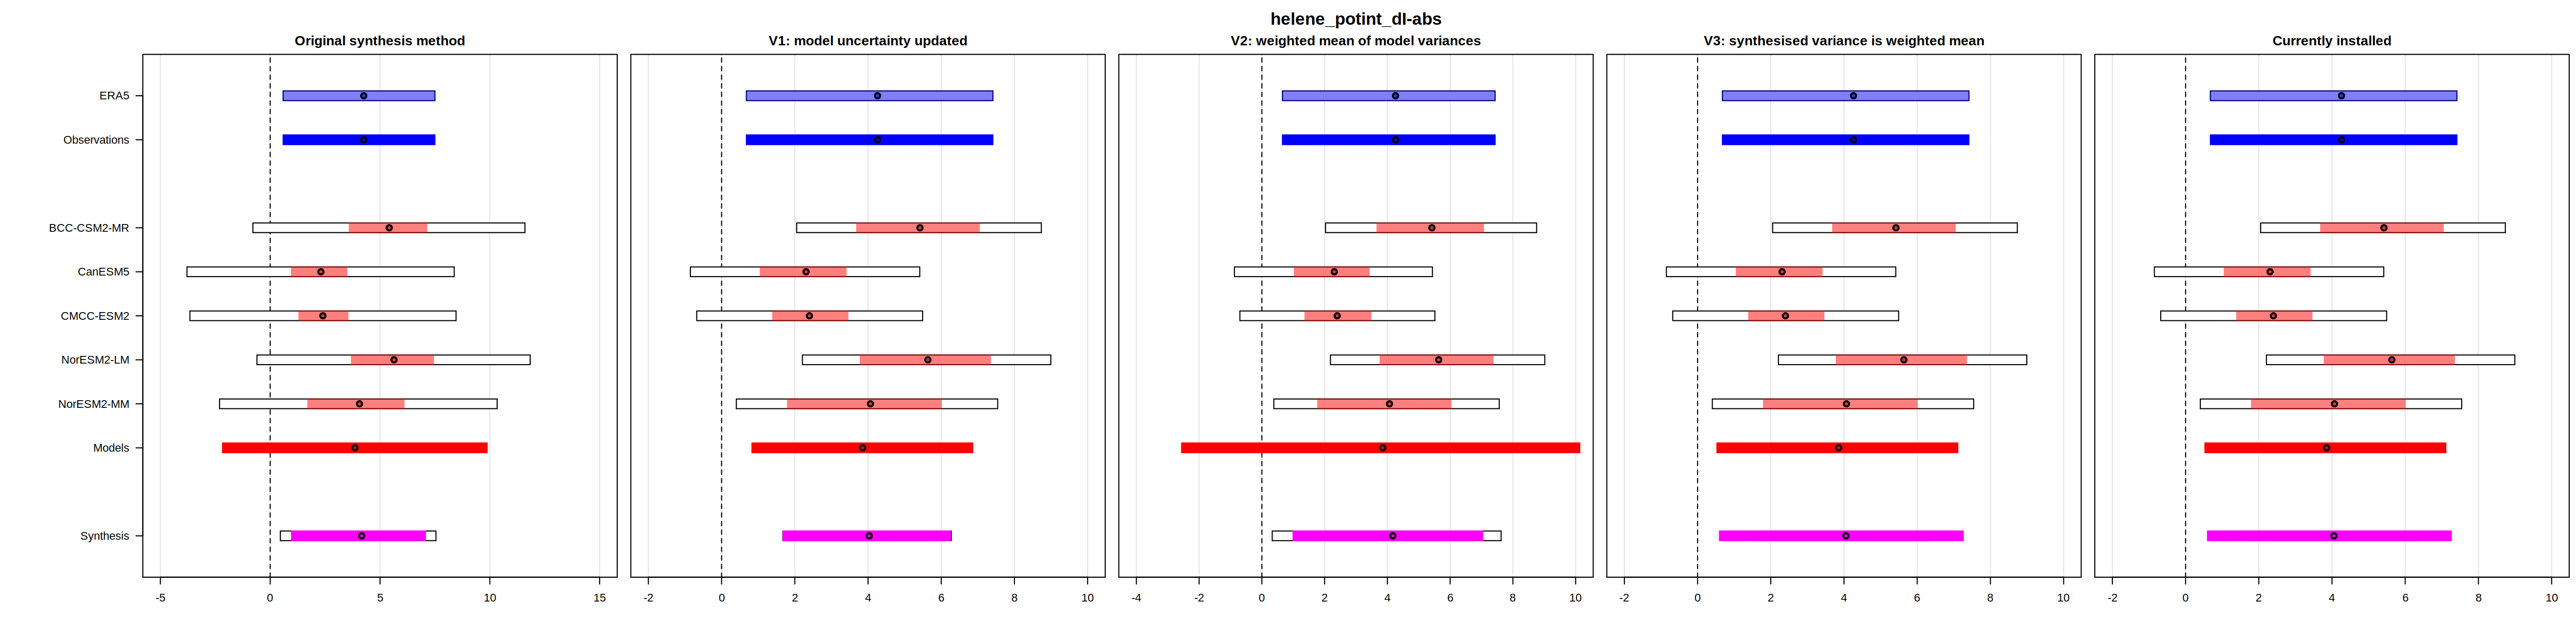

In [142]:
res <- read.csv(fnm, row.names = 2)
obs = res[res$src == "obs",-1]
models = res[res$src == "models",-1]

stype <- switch(strsplit(gsub(".csv","",fnm), "_")[[1]][3], "PR" = "PR", "dI-abs" = "abs", "dI-rel" = "rel")

synth_org = synthesis_cx(obs, models, synth_type = stype)      # original code from Climate Explorer
synth_v1 = synthesis_v1(obs, models, synth_type = stype)       # modified to use variances instead of mixing intervals & variances
synth_v2 = synthesis_v2(obs, models, synth_type = stype)       # model variances averaged rather than summing precisions
synth_v3 = synthesis_v3(obs, models, synth_type = stype)       
synth_v0 = synthesis(obs, models, synth_type = stype)             # version currently installed on GitHub

cat("Spread of model means:",round(diff(range(models$est)),2),"\n")
cat("Width of 95% interval from SD:", round(2*1.96*sd(models$est), 2),"\n")

cat("Width of red bar:", sapply(c("org", "v1", "v2", "v3", "v0"), function(v) {
    paste0(round(diff(unlist(get(paste0("synth_",v))$df[get(paste0("synth_",v))$df$group == "model_synth", c("lower", "upper")])),2))
}), "\n")
cat("Width of purple bar:", sapply(c("org", "v1", "v2", "v3", "v0"), function(v) {
    paste0(round(diff(unlist(get(paste0("synth_",v))$df[get(paste0("synth_",v))$df$group == "synth", c("lower", "upper")])),2))
}), "\n")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# png(gsub("data","fig",gsub("csv","png",fnm)), height = max(20 * nrow(res)+3, 240), width = 360 * 4); {
    prep_window(c(1,5), h = 6, w = 5, mar = c(3,0.5,2,0.5), oma = c(0,10,2,0))
    plot_synthesis(synth_org, main = "Original synthesis method")
    plot_synthesis(synth_v1, main = v1_desc, hide_labels = T)
    plot_synthesis(synth_v2, main = v2_desc, hide_labels = T)
    plot_synthesis(synth_v3, main = v3_desc, hide_labels = T)
    plot_synthesis(synth_v0, main = "Currently installed", hide_labels = T)

    mtext(gsub("data/","",gsub(".csv","",fnm)), side = 3, outer = T, font = 2)
# }; dev.off()

# Check Fortran updates

## Original synthesis functions

In [143]:
getsynmean <- function(data, sig_mod = 0) {

  # calculate weight for each model based on inverse variance
  w = 1/(((data$upper - data$lower))^2 + (2*sig_mod)^2)
  w1 = sum(w)

  # weighted sum of squares & bounds
  s1 <- sum(w*data$est) / w1
  ss2 <- apply(data[,c("est", "lower", "upper")], 2, function(b) sum((w*(data$est - b))^2))
  ss2 <- sqrt(ss2) / w1

  # if non-zero model representation error, extend 95% intervals accordingly
  if (sig_mod > 0) { ss2 <- sqrt(ss2^2 + (sig_mod)^2) }

  return(s1 + (ss2 * c(0,-1,1)))
}


################################################################################################################################
getsynchi2 <- function(data, sig_mod = 0) {

  # function to be minimized by finding sig_mod such that chi^2/mdof ~= 1

  # get best estimate of weighted mean
  s1 <- getsynmean(data, sig_mod)["est"]

  # compute chi2 by converting model intervals to standard deviations & adding sig_mod adjustment
  chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
    if(x["est"] > s1) {
      (x["est"] - s1)^2 / (((x["est"] - x["lower"]))^2 + (sig_mod)^2)
    } else {
      (x["est"] - s1)^2 / (((x["est"] - x["upper"]))^2 + (sig_mod)^2)
    }
  }))
  return(chi2*4)
}


################################################################################################################################
synthesis <- function(obs_in = NA, models_in, synth_type = "abs") {

  if(is.na(unlist(obs_in))[1]) {
    no_obs <- T
    # create a dummy dataframe to avoid having to rewrite everything twice
    obs_in <- data.frame("est" = 0, "lower" = 0, "upper" = 0)
    rownames(obs_in) <- "dummy"
  } else {
    no_obs <- F
  }

  # relabel the data for easier reference later
  colnames(obs_in) <- colnames(models_in) <- c("est", "lower", "upper")

  if(!("model" %in% colnames(obs_in))) obs_in$model <- rownames(obs_in)
  if(!("model" %in% colnames(models_in))) models_in$model <- rownames(models_in)

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

  if(!synth_type %in% c("abs", "rel", "PR")) {
    cat(paste0("Synthesis type '",synth_type,"' not implemented - must be abs, rel or PR"), "\n")
  }

  if(synth_type == "PR") {
    obs_in[,c("est", "lower", "upper")] <- log(obs_in[,c("est", "lower", "upper")])
    models_in[,c("est", "lower", "upper")] <- log(models_in[,c("est", "lower", "upper")])
  } else if(synth_type == "rel") {
    obs_in[,c("est", "lower", "upper")] <- log(1+obs_in[,c("est", "lower", "upper")]/100)
    models_in[,c("est", "lower", "upper")] <- log(1+models_in[,c("est", "lower", "upper")]/100)
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # get mean of intervals to estimate natural variability component

  # compute representation error from scatter of mean ($\sigma_{rep}$ in the paper)
  nobs = nrow(obs_in)
  obs <- apply(obs_in[,c("est", "lower", "upper"),drop = F], 2, mean)
  if(nobs == 1) {
    sig_obs = 0
  } else {
    s2 = sum((obs_in$est - obs[1])^2)
    sig_obs = sqrt(s2/(nobs-1))
  }

  # add representation error to individual observations
  obs_in$l_wb <- obs_in$est - sqrt((obs_in$est - obs_in$lower)**2 + (1.96*sig_obs)**2)
  obs_in$u_wb <- obs_in$est + sqrt((obs_in$est - obs_in$upper)**2 + (1.96*sig_obs)**2)

  # apply representation error to obs synthesis
  # we're working with confidence intervals here, so we extend them by adding (1.96sig_obs)^2 in quadrature
  obs[2] <- obs[1] - sqrt( (obs[1] - obs[2])**2 + (1.96*sig_obs)**2 )
  obs[3] <- obs[1] + sqrt( (obs[1] - obs[3])**2 + (1.96*sig_obs)**2 )

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # get initial estimate of model mean & calculate chi^2
  chi2 <- getsynchi2(models_in, sig_mod = 0)
  mdof <- nrow(models_in)-1

  if ( chi2/mdof > 1 ) {
    # find sig_mod such that chi^2/dof = 1
    sig_mod <- optim(0, function(x) {(getsynchi2(models_in, sig_mod = x) - (nrow(models_in)-1))^2},
                     method = "Brent", lower = 0, upper = 5)$par
  } else {
    sig_mod <- 0
  }

  # get weighted model mean
  models <- getsynmean(models_in, sig_mod = sig_mod)

  # add representation error to individual models
  models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + (1.96*sig_mod)**2)
  models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + (1.96*sig_mod)**2)

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # weighted mean of models & obs (coloured bar)
  w_obs <- unname((obs["upper"] - obs["lower"])^{-2})
  w_mod <- unname((models["upper"] - models["lower"])^{-2})

  wmean <- (w_obs * obs["est"] + w_mod * models["est"]) / (w_obs + w_mod)
  synth <- setNames(c(wmean,
                      wmean - sqrt( (w_obs*(obs["est"]-obs["lower"]))^2 + (w_mod*(models["est"]-models["lower"]))^2 )/(w_obs+w_mod),
                      wmean + sqrt( (w_obs*(obs["est"]-obs["upper"]))^2 + (w_mod*(models["est"]-models["upper"]))^2 )/(w_obs+w_mod)),
                    c("est", "lower", "upper"))


  # unweighted mean of obs and models
  umean <- (obs["est"] +  models["est"]) / 2
  synth["l_wb"] <- umean - sqrt((obs["est"]-obs["lower"])^2 + (models["est"]-models["lower"])^2)/2
  synth["u_wb"] <- umean + sqrt((obs["est"]-obs["upper"])^2 + (models["est"]-models["upper"])^2)/2

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # add group labels for easier plotting
  obs_in <- cbind(obs_in, "group" = "obs")
  obs <- data.frame(t(c("model" = "Observations", "group" = "obs_synth", obs)))
  models_in <- cbind(models_in, "group" = "models")
  models <- data.frame(t(c("model" = "Models", "group" = "model_synth", models)))
  synth <- data.frame(t(c("model" = "Synthesis", "group" = "synth", synth)))

  # combine all the data together in one dataframe
  res <- rbind.fill(obs_in, obs, models_in, models, synth)[,c("group", "model", "est", "lower", "upper", "l_wb", "u_wb")]
  for(cnm in c("est", "lower", "upper", "l_wb", "u_wb")) { res[,cnm] <- as.numeric(res[,cnm]) }

  # if only dummy obs, remove
  if(no_obs) {
    # drop all rows that don't relate to models
    res <- res[grepl("model", res$group),]
    sig_obs <- NA
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # reverse any transformations applied
  if(synth_type == "PR") {
    res[,c("est", "lower", "upper", "l_wb", "u_wb")] <- exp(res[,c("est", "lower", "upper", "l_wb", "u_wb")])
    sig_obs <- exp(sig_obs)
    sig_mod <- exp(sig_mod)
    umean <- exp(umean)
  } else if(synth_type == "rel") {
    res[,c("est", "lower", "upper", "l_wb", "u_wb")] <- 100*(exp(res[,c("est", "lower", "upper", "l_wb", "u_wb")])-1)
    sig_obs <- 100*(exp(sig_obs)-1)
    sig_mod <- 100*(exp(sig_mod)-1)
    umean <- 100*(exp(umean)-1)
  }

  return(list(synth_type = synth_type, sig_obs = sig_obs, "chi2/dof" = chi2 / mdof, df = res, uw_mean = umean))
}

## Revised getsynchi2

In [144]:
getsynmean_rev1 <- function(data, sig_mod = 0) {

  # calculate weight for each model based on inverse variance
  w = 1/(((data$upper - data$lower))^2 + (2*sig_mod)^2)
  w1 = sum(w)

  # weighted sum of squares & bounds
  s1 <- sum(w*data$est) / w1
  ss2 <- apply(data[,c("est", "lower", "upper")], 2, function(b) sum((w*(data$est - b))^2))
  ss2 <- sqrt(ss2) / w1

  # if non-zero model representation error, extend 95% intervals accordingly
  if (sig_mod > 0) { ss2 <- sqrt(ss2^2 + (sig_mod)^2) }

  return(s1 + (ss2 * c(0,-1,1)))
}


################################################################################################################################
getsynchi2_rev1 <- function(data, sig_mod = 0) {

  # function to be minimized by finding sig_mod such that chi^2/mdof ~= 1

  # get best estimate of weighted mean
  s1 <- getsynmean_rev1(data, sig_mod)["est"]

  # compute chi2 by converting model intervals to standard deviations & adding sig_mod adjustment
  chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
    if(x["est"] > s1) {
      (x["est"] - s1)^2 / (((x["est"] - x["lower"])/2)^2 + (sig_mod)^2)    # MODIFIED
    } else {
      (x["est"] - s1)^2 / (((x["est"] - x["upper"])/2)^2 + (sig_mod)^2)    # MODIFIED
    }
  }))
  return(chi2)
}


################################################################################################################################
synthesis_rev1 <- function(obs_in = NA, models_in, synth_type = "abs") {

  if(is.na(unlist(obs_in))[1]) {
    no_obs <- T
    # create a dummy dataframe to avoid having to rewrite everything twice
    obs_in <- data.frame("est" = 0, "lower" = 0, "upper" = 0)
    rownames(obs_in) <- "dummy"
  } else {
    no_obs <- F
  }

  # relabel the data for easier reference later
  colnames(obs_in) <- colnames(models_in) <- c("est", "lower", "upper")

  if(!("model" %in% colnames(obs_in))) obs_in$model <- rownames(obs_in)
  if(!("model" %in% colnames(models_in))) models_in$model <- rownames(models_in)

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

  if(!synth_type %in% c("abs", "rel", "PR")) {
    cat(paste0("Synthesis type '",synth_type,"' not implemented - must be abs, rel or PR"), "\n")
  }

  if(synth_type == "PR") {
    obs_in[,c("est", "lower", "upper")] <- log(obs_in[,c("est", "lower", "upper")])
    models_in[,c("est", "lower", "upper")] <- log(models_in[,c("est", "lower", "upper")])
  } else if(synth_type == "rel") {
    obs_in[,c("est", "lower", "upper")] <- log(1+obs_in[,c("est", "lower", "upper")]/100)
    models_in[,c("est", "lower", "upper")] <- log(1+models_in[,c("est", "lower", "upper")]/100)
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # get mean of intervals to estimate natural variability component

  # compute representation error from scatter of mean ($\sigma_{rep}$ in the paper)
  nobs = nrow(obs_in)
  obs <- apply(obs_in[,c("est", "lower", "upper"),drop = F], 2, mean)
  if(nobs == 1) {
    sig_obs = 0
  } else {
    s2 = sum((obs_in$est - obs[1])^2)
    sig_obs = sqrt(s2/(nobs-1))
  }

  # add representation error to individual observations
  obs_in$l_wb <- obs_in$est - sqrt((obs_in$est - obs_in$lower)**2 + (1.96*sig_obs)**2)
  obs_in$u_wb <- obs_in$est + sqrt((obs_in$est - obs_in$upper)**2 + (1.96*sig_obs)**2)

  # apply representation error to obs synthesis
  # we're working with confidence intervals here, so we extend them by adding (1.96sig_obs)^2 in quadrature
  obs[2] <- obs[1] - sqrt( (obs[1] - obs[2])**2 + (1.96*sig_obs)**2 )
  obs[3] <- obs[1] + sqrt( (obs[1] - obs[3])**2 + (1.96*sig_obs)**2 )

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # get initial estimate of model mean & calculate chi^2
  chi2 <- getsynchi2_rev1(models_in, sig_mod = 0)
  mdof <- nrow(models_in)-1

  if ( chi2/mdof > 1 ) {
    # find sig_mod such that chi^2/dof = 1
    sig_mod <- optim(0, function(x) {(getsynchi2_rev1(models_in, sig_mod = x) - (nrow(models_in)-1))^2},
                     method = "Brent", lower = 0, upper = 5)$par
  } else {
    sig_mod <- 0
  }

  # get weighted model mean
  models <- getsynmean_rev1(models_in, sig_mod = sig_mod)

  # add representation error to individual models
  models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + (1.96*sig_mod)**2)
  models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + (1.96*sig_mod)**2)

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # weighted mean of models & obs (coloured bar)
  w_obs <- unname((obs["upper"] - obs["lower"])^{-2})
  w_mod <- unname((models["upper"] - models["lower"])^{-2})

  wmean <- (w_obs * obs["est"] + w_mod * models["est"]) / (w_obs + w_mod)
  synth <- setNames(c(wmean,
                      wmean - sqrt( (w_obs*(obs["est"]-obs["lower"]))^2 + (w_mod*(models["est"]-models["lower"]))^2 )/(w_obs+w_mod),
                      wmean + sqrt( (w_obs*(obs["est"]-obs["upper"]))^2 + (w_mod*(models["est"]-models["upper"]))^2 )/(w_obs+w_mod)),
                    c("est", "lower", "upper"))


  # unweighted mean of obs and models
  umean <- (obs["est"] +  models["est"]) / 2
  synth["l_wb"] <- umean - sqrt((obs["est"]-obs["lower"])^2 + (models["est"]-models["lower"])^2)/2
  synth["u_wb"] <- umean + sqrt((obs["est"]-obs["upper"])^2 + (models["est"]-models["upper"])^2)/2

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # add group labels for easier plotting
  obs_in <- cbind(obs_in, "group" = "obs")
  obs <- data.frame(t(c("model" = "Observations", "group" = "obs_synth", obs)))
  models_in <- cbind(models_in, "group" = "models")
  models <- data.frame(t(c("model" = "Models", "group" = "model_synth", models)))
  synth <- data.frame(t(c("model" = "Synthesis", "group" = "synth", synth)))

  # combine all the data together in one dataframe
  res <- rbind.fill(obs_in, obs, models_in, models, synth)[,c("group", "model", "est", "lower", "upper", "l_wb", "u_wb")]
  for(cnm in c("est", "lower", "upper", "l_wb", "u_wb")) { res[,cnm] <- as.numeric(res[,cnm]) }

  # if only dummy obs, remove
  if(no_obs) {
    # drop all rows that don't relate to models
    res <- res[grepl("model", res$group),]
    sig_obs <- NA
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # reverse any transformations applied
  if(synth_type == "PR") {
    res[,c("est", "lower", "upper", "l_wb", "u_wb")] <- exp(res[,c("est", "lower", "upper", "l_wb", "u_wb")])
    sig_obs <- exp(sig_obs)
    sig_mod <- exp(sig_mod)
    umean <- exp(umean)
  } else if(synth_type == "rel") {
    res[,c("est", "lower", "upper", "l_wb", "u_wb")] <- 100*(exp(res[,c("est", "lower", "upper", "l_wb", "u_wb")])-1)
    sig_obs <- 100*(exp(sig_obs)-1)
    sig_mod <- 100*(exp(sig_mod)-1)
    umean <- 100*(exp(umean)-1)
  }

  return(list(synth_type = synth_type, sig_obs = sig_obs, "chi2/dof" = chi2 / mdof, df = res, uw_mean = umean))
}

In [145]:
fnm <- "data/helene_potint_dI-abs.csv"
res <- read.csv(fnm, row.names = 2)
obs = res[res$src == "obs",-1]
models = res[res$src == "models",-1]

stype <- switch(strsplit(gsub(".csv","",fnm), "_")[[1]][3], "PR" = "PR", "dI-abs" = "abs", "dI-rel" = "rel")

synth_vx = synthesis(obs, models, synth_type = stype)             # should match current Climate Explorer code
synth_rev1 = synthesis_rev1(obs, models, synth_type = stype)             # should match current Climate Explorer code

In [146]:
# modified getsynchi2 to remove scaling by factor of 4 - chi2/dof is same but white boxes are slightly different
synth_rev1

group,model,est,lower,upper,l_wb,u_wb
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
obs,ERA5,4.260000,0.810000,7.280000,0.8100000,7.280000
obs_synth,Observations,4.260000,0.810000,7.280000,NA,NA
models,BCC-CSM2-MR,5.419148,3.823571,6.907285,2.1521897,8.635000
models,CanESM5,2.308114,1.190206,3.267051,-0.7540533,5.315889
models,CMCC-ESM2,2.399358,1.529618,3.318917,-0.5811785,5.394811
models,NorESM2-LM,5.635606,3.921809,7.212483,2.3093092,8.893472
models,NorESM2-MM,4.066910,1.933599,5.871118,0.5062687,7.440679
model_synth,Models,3.670778,2.092219,5.230303,NA,NA
synth,Synthesis,3.782992,2.346050,5.170346,2.0683948,5.664839


In [147]:
# # Generated by synthesis version synthesis
# # synthesis update 2021-12-15
# # Change in intensity, past-present, RX1day, Earth, 2 yr
# # model chi2/dof =      5.762    
# # model uncertainty (2&sigma;)     2.89    
#  1900 2024    4.26       0.810        7.28       0.810        7.28      2 "ERA5 "
#  1900 2024    5.42        3.82        6.91        2.12        8.67      3 "BCC-CSM2-MR (1) "
#  1900 2024    2.31        1.19        3.27      -0.786        5.35      3 "CanESM5 (1) "
#  1900 2024    2.40        1.53        3.32      -0.614        5.43      3 "CMCC-ESM2 (1) "
#  1900 2024    5.64        3.92        7.21        2.28        8.92      3 "NorESM2-LM (1) "
#  1900 2024    4.07        1.93        5.87       0.479        7.47      3 "NorESM2-MM (1) "
#  1900 2024    3.86       0.898        6.80       0.898        6.80      4 "models "
#  1900 2024    4.04        1.79        6.15        1.79        6.17      5 "synthesis "

In [148]:
.7**2

[1] 0.49

In [149]:
1.2^2

[1] 1.44

In [150]:
.49+1.44

[1] 1.93

In [151]:
sqrt(1.93)

[1] 1.389244

In [152]:
1/.7

[1] 1.428571

In [153]:
sig_obs = 0.7
sig_mod = 1.2

w_obs = 1/sig_obs^2
w_mod = 1/sig_mod^2

In [154]:
# theoretical synthesised variance
sig2_synth <- ((w_obs * sig_obs^2) + (w_mod * sig_mod^2)) / (w_obs + w_mod)
sig2_synth

# check against simplified version
2 / (w_obs + w_mod)

[1] 0.7311917

[1] 0.7311917

In [155]:
# expected interval width
1.96*sqrt(2/(w_obs + w_mod))

[1] 1.675991

In [156]:
# use interval widths to estimate sigma
mu_obs <- 0
qu_obs <- mu_obs + qnorm(.975, mu_obs, sig_obs)
sighat_obs <- (qu_obs - mu_obs) / 1.96

mu_mod <- 0
qu_mod <- mu_mod + qnorm(.975, mu_mod, sig_mod)
sighat_mod <- (qu_mod - mu_mod) / 1.96

In [157]:
# estimate the overall variance
(w_obs * sighat_obs^2 + w_mod * sighat_mod^2) / (w_obs + w_mod)

[1] 0.7311648

In [158]:
# estimate the interval width
1.96 * sqrt((w_obs * sighat_obs^2 + w_mod * sighat_mod^2) / (w_obs + w_mod))

[1] 1.67596

In [159]:
# unweighted variance
uvar <- ((.5 * sig_obs^2) + (.5 * sig_mod^2))

# interval from unweighted variance
1.96*sqrt(uvar)

[1] 1.925395

In [160]:
# unweighted interval
1.96 * sqrt((0.5 * sighat_obs^2 + 0.5 * sighat_mod^2) / (0.5 + 0.5))

[1] 1.925359

---
The weighted variance is 

$\begin{align}
\sigma^2_{synth} = \frac{w_{obs}\hat{\sigma}_{obs}^2 + w_{mod}\hat{\sigma}_{mod}^2}{w_{obs} + w_{mod}}
\end{align}$

where for the upper interval, the SD is estimated as
$\begin{align}
\hat{\sigma}_{obs} = \left(q_{obs}^{(u)} - \mu_{obs}\right) / 1.96.
\end{align}$

The weighted variance based on the upper bound is therefore

$\begin{align}
\hat{\sigma}_{synth}^2
= \frac{w_{obs}\left(\frac{q_{obs}^{(u)} - \mu_{obs}}{1.96}\right)^2 + w_{mod}\left(\frac{q_{mod}^{(u)} - \mu_{mod}}{1.96}\right)^2}{w_{obs} + w_{mod}}
= \frac{w_{obs}\left(q_{obs}^{(u)} - \mu_{obs}\right)^2 + w_{mod}\left(q_{mod}^{(u)} - \mu_{mod}\right)^2}{1.96^2\left(w_{obs} + w_{mod}\right)}
\end{align}$

and the width of the upper part of the associated 95% confidence interval is

$\begin{align}
q^{(u)}_{synth} = 1.96\sqrt{\hat{\sigma}_{synth}^2}
= 1.96\sqrt{\frac{w_{obs}\left(q_{obs}^{(u)} - \mu_{obs}\right)^2 + w_{mod}\left(q_{mod}^{(u)} - \mu_{mod}\right)^2}{1.96^2\left(w_{obs} + w_{mod}\right)}}
= \sqrt{\frac{w_{obs}\left(q_{obs}^{(u)} - \mu_{obs}\right)^2 + w_{mod}\left(q_{mod}^{(u)} - \mu_{mod}\right)^2}{w_{obs} + w_{mod}}}
\end{align}$

In [161]:
sigu_obs <- 0.8; sigl_obs <- 0.8; mu_obs <- 0
sigu_mod <- 0.8; sigl_mod <- 0.8; mu_mod <- 0

In [162]:
# get the interval bounds (the quantities we would actually be working with)
ql_obs <- qnorm(0.025, mu_obs, sigl_obs)
qu_obs <- qnorm(0.975, mu_obs, sigu_obs)

ql_mod <- qnorm(0.025, mu_mod, sigl_mod)
qu_mod <- qnorm(0.975, mu_mod, sigu_mod)

# compute weights (based on total interval width, even when asymmetric)
w_obs <- ((qu_obs - ql_obs) / 3.92)^2
w_mod <- ((qu_mod - ql_mod) / 3.92)^2

In [163]:
# get the weighted bounds
qu_synth <- sqrt((w_obs * (qu_obs - mu_obs)^2 + w_mod * (qu_obs - mu_obs)^2) / (w_obs + w_mod))
ql_synth <- sqrt((w_obs * (ql_obs - mu_obs)^2 + w_mod * (ql_obs - mu_obs)^2) / (w_obs + w_mod))

In [164]:
w_obs

[1] 0.6399765